In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('data/movies/ratings.csv 
dataset.head(10)

,user_id,item_id,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [4]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 3

Using TensorFlow backend.


In [5]:
from keras.callbacks import Callback

class Metrics(Callback):

    def on_train_begin(self, logs={}):
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):

        val_recall = calculate_average_recall_at_k(self.model, test, k=5, treshold=3.5)
        val_precision = calculate_average_precision_at_k(self.model, test, k=5, treshold=3.5)

        self.val_recalls.append(val_recall)
        self.val_precisions.append(val_precision)
        print(f' - precision@{k}: {val_precision} - recall@{k}: {val_recall}')
        return

def get_top_k_items(items, predicted, k):
    top_k = (predicted.sort_values()[-k:])
    return items[top_k.index]

def calculate_average_precision_at_k(model, test, k=5, treshold=3.5):
    test['predicted'] = model.predict([test.user_id, test.item_id])
    users = list(set(test['user_id']))

    precisions_for_each_user = []
    for user in users:
        sample = test[test.user_id == user]
        top_k = get_top_k_items(sample['item_id'], sample['predicted'], k)
        precision = sum(sample['rating'][top_k.index] > treshold) / k
        precisions_for_each_user.append(precision)
    average_precision = np.mean(precisions_for_each_user)
    return np.round(average_precision, 4)

def calculate_average_recall_at_k(model, test, k=5, treshold=3.5):
    test['predicted'] = model.predict([test.user_id, test.item_id])
    users = list(set(test['user_id']))

    recall_for_each_user = []
    for user in users:
        sample = test[test.user_id == user]
        top_k = get_top_k_items(sample['item_id'], sample['predicted'], k)
        recall = sum(sample['rating'][top_k.index] > treshold) / len(sample['rating'])
        recall_for_each_user.append(recall)
    average_recall = np.mean(recall_for_each_user)
    return np.round(average_recall, 4)

k = 10
metrics = Metrics()

In [6]:
# Matrix factorisation model
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
model_mf = keras.Model([user_input, movie_input], prod)
model_mf.compile('adam', 'mean_squared_error')
model_mf.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         27201       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         2016        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [7]:
history_mf = model_mf.fit([train.user_id, train.item_id], train.rating, epochs=15, batch_size=64, callbacks=[metrics])

Epoch 1/15
90003/90003 [==============================] - 4s 44us/step - loss: 12.9892
Epoch 2/15
90003/90003 [==============================] - 5s 51us/step - loss: 7.6918
Epoch 3/15
90003/90003 [==============================] - 3s 39us/step - loss: 4.0416
Epoch 4/15
90003/90003 [==============================] - 4s 44us/step - loss: 2.6834
Epoch 5/15
90003/90003 [==============================] - 5s 55us/step - loss: 1.9964
Epoch 6/15
90003/90003 [==============================] - 4s 47us/step - loss: 1.5953
Epoch 7/15
90003/90003 [==============================] - 4s 45us/step - loss: 1.3424
Epoch 8/15
90003/90003 [==============================] - 4s 49us/step - loss: 1.1746
Epoch 9/15
90003/90003 [==============================] - 4s 43us/step - loss: 1.0582
Epoch 10/15
90003/90003 [==============================] - 4s 43us/step - loss: 0.9749
Epoch 11/15
90003/90003 [==============================] - 4s 43us/step - loss: 0.9138
Epoch 12/15
90003/90003 [==========================

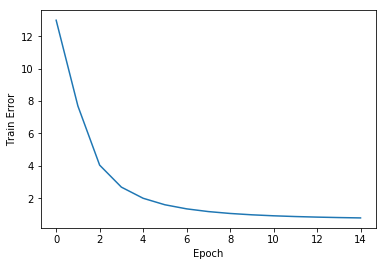

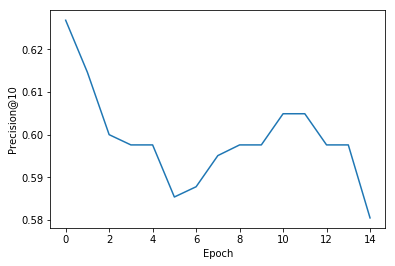

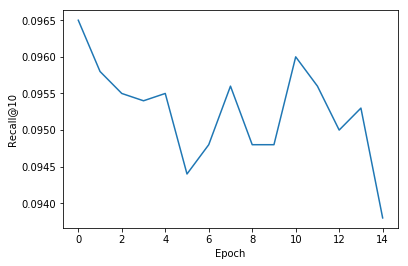

In [8]:
pd.Series(history_mf.history['loss']).plot()
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()
pd.Series(metrics.val_precisions).plot()
plt.xlabel('Epoch')
plt.ylabel(f'Precision@{k}')
plt.show()

pd.Series(metrics.val_recalls).plot()
plt.xlabel('Epoch')
plt.ylabel(f'Recall@{k}')
plt.show()

In [9]:
graphs['precision_mf'] = metrics.val_precisions
graphs['recall_mf'] = metrics.val_precisions

In [10]:
# Neural networks model

n_latent_factors_user = 4
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = keras.layers.merge([movie_vec, user_vec], mode='concat',name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(128,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(64,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(32,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(16,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model_nn = keras.Model([user_input, movie_input], result)
model_nn.compile(optimizer=adam,loss= 'mean_absolute_error')
model_nn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 8)         72536       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 4)         2688        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [11]:
history_nn = model_nn.fit([train.user_id, train.item_id], train.rating, epochs=15, batch_size=64, callbacks=[metrics])

Epoch 1/15
90003/90003 [==============================] - 6s 69us/step - loss: 0.7542
Epoch 2/15
90003/90003 [==============================] - 6s 68us/step - loss: 0.6883
Epoch 3/15
90003/90003 [==============================] - 7s 72us/step - loss: 0.6688
Epoch 4/15
90003/90003 [==============================] - 7s 77us/step - loss: 0.6591
Epoch 5/15
90003/90003 [==============================] - 7s 76us/step - loss: 0.6523
Epoch 6/15
90003/90003 [==============================] - 7s 80us/step - loss: 0.6446
Epoch 7/15
90003/90003 [==============================] - 7s 72us/step - loss: 0.6406
Epoch 8/15
90003/90003 [==============================] - 6s 70us/step - loss: 0.6361
Epoch 9/15
90003/90003 [==============================] - 6s 70us/step - loss: 0.6343
Epoch 10/15
90003/90003 [==============================] - 6s 70us/step - loss: 0.6286
Epoch 11/15
90003/90003 [==============================] - 6s 70us/step - loss: 0.6268
Epoch 12/15
90003/90003 [===========================

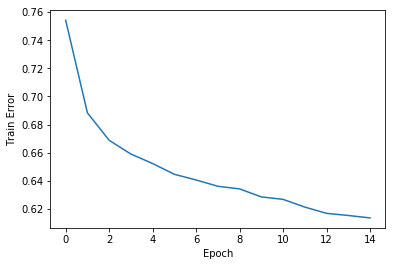

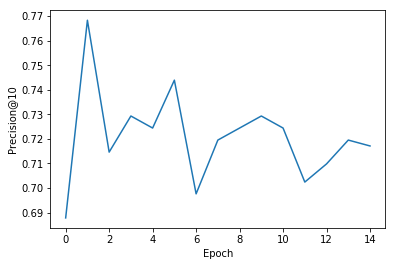

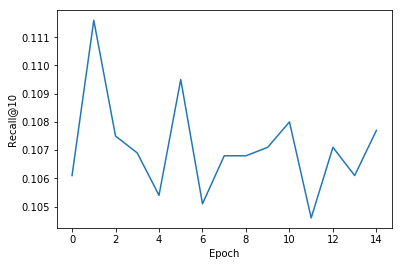

In [12]:
pd.Series(history_nn.history['loss']).plot()
plt.xlabel('Epoch')
plt.ylabel('Train Error')
plt.show()

pd.Series(metrics.val_precisions).plot()
plt.xlabel('Epoch')
plt.ylabel(f'Precision@{k}')
plt.show()

pd.Series(metrics.val_recalls).plot()
plt.xlabel('Epoch')
plt.ylabel(f'Recall@{k}')
plt.show()

In [13]:
graphs['precision_nn'] = metrics.val_precisions
graphs['recall_nn'] = metrics.val_precisions

In [14]:
graphs.to_csv('movies_precision_recall.csv', index=None)